# Check VE, Yeo, and Laminar Differentiation associations

In [3]:
%cd work/notebooks

/home/jovyan/work/notebooks


In [1]:
# Import modules and R
import numpy as np, pandas as pd
from plotnine import *
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [5]:
import sys, os
sys.path.append('../code/')
from processing_helpers import *
from analysis_helpers import *
from gradientVersion import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");

Get gradients

In [6]:
dm_hcp_ds8 = gradientVersion().fit('hcp_ds8')
# dm_hcp_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')
# pca_hcp_3d_ds8 = gradientVersion(approach='pca').fit('hcp_3donors_ds8')

New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_ds8


In [7]:
scores = dm_hcp_ds8.clean_scores()
null_scores = np.load("../outputs/permutations/hcp_ds8_sim_5000.npy")

## Get region labels

In [25]:
yeo_labels = {1:'visual',2:'somatomotor',3:'dorsal attention',4:'ventral attention',5:'limbic',6:'frontoparietal',7:'default mode'}

yeo = (pd.read_csv("../data/vonEconomo_Yeo.csv")
       .loc[lambda x: x['HCP'].str[:2] == 'L_']['Yeo']
       .set_axis([i+1 for i in range(180)])
       .loc[lambda x: x!=8]
       .replace(yeo_labels)
       .to_frame().join(get_labels_hcp())       
      )
yeo

FileNotFoundError: [Errno 2] No such file or directory: '../data/vonEconomo_Yeo.csv'

In [399]:
vonEconomo_labels = {1:'motor',2:'association1',3:'association2',4:'sensory2',5:'sensory1',6:'limbic',7:'insula'}

ve = (pd.read_csv("../data/vonEconomo_Yeo.csv")
       .loc[lambda x: x['HCP'].str[:2] == 'L_']['vonEconomo']
       .set_axis([i+1 for i in range(180)])
       .replace(vonEconomo_labels)
       .to_frame().join(get_labels_hcp())
      )
ve.vonEconomo.unique()

array(['sensory1', 'sensory2', 'association1', 'motor', 'limbic',
       'association2', 'insula'], dtype=object)

## Make laminar differentiation map in glasser

In [9]:
laminar_diff = np.genfromtxt("../data/mesulam_fsa5.csv", delimiter=',')[:10242]

In [10]:
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage5')

In [12]:
# from nilearn import plotting
# plotting.plot_surf_roi(fsaverage['infl_left'], roi_map=laminar_diff,
#                        hemi='left', view='lateral',
#                        bg_map=fsaverage['sulc_left'], bg_on_data=True,
#                        darkness=.5);
# plotting.plot_surf_roi(fsaverage['infl_left'], roi_map=laminar_diff,
#                        hemi='left', view='medial',
#                        bg_map=fsaverage['sulc_left'], bg_on_data=True,
#                        darkness=.5);

In [138]:
annot_to_gifti("../data/parcellations/lh.HCP.fsaverage.aparc.annot")[0].agg_data()

array([ 54,  49,  41, ..., 122, 122, 122])

In [16]:
from neuromaps.images import annot_to_gifti
from neuromaps.transforms import fsaverage_to_fsaverage
hcp_fsa7 = annot_to_gifti("../data/parcellations/lh.HCPMMP1.annot")
hcp_fsa5 = fsaverage_to_fsaverage(hcp_fsa7, '10k', hemi='L', method='nearest')
hcp_fsa5

SubprocessError: Command failed with non-zero exit status 127. Error traceback: "/bin/sh: 1: wb_command: not found"

In [20]:
import nibabel as nib
# nib.save(hcp_fsa5[0], '../data/parcellations/hcp_fsa5.label.gii')
hcp_fsa5 = (nib.load('../data/parcellations/hcp_fsa5.label.gii'),)

In [21]:
(hcp_fsa5[0].agg_data()==1).sum()

259

In [22]:
labels_to_agg = laminar_diff
parcellation_labels = hcp_fsa5[0].agg_data()

def get_mode_of_labels_in_parcellation(labels_to_agg, parcellation_labels):
    arr = np.zeros([181, 10242])
    for i in range(arr.shape[0]):
        arr[i,:] = labels_to_agg
        arr[i, parcellation_labels!=i] = np.nan

    from scipy.stats import mode
    labels_in_parc = mode(arr, axis=1, nan_policy='omit')[0].data.squeeze()
    
    return labels_in_parc

mesulam_colors = {1:"#FFFFB3", 2:"#BEBADA", 3:"#FB8072", 4:"#80B1D3"}
mesulam_names = {1:'Paralimbic',2:'Heteromodal',3:'Unimodal',4:'Idiotypic'}

mesulam_hcp = get_mode_of_labels_in_parcellation(labels_to_agg, parcellation_labels)
mesulam_hcp = (pd.DataFrame({'label':get_labels_hcp()[:180],
                             'Mesulam':mesulam_hcp[1:].astype('int')})
                    .assign(Mesulam_colors = lambda x: x['Mesulam'].map(mesulam_colors))
                    .assign(Mesulam_names = lambda x: 
                            pd.Categorical(x['Mesulam'].replace(mesulam_names), 
                                           categories=mesulam_names.values()))
                   )
mesulam_hcp.to_csv("../data/mesulam_hcp.csv")
mesulam_hcp

,label,Mesulam,Mesulam_colors,Mesulam_names
id,,,,
1,V1,4,#80B1D3,Idiotypic
2,MST,3,#FB8072,Unimodal
3,V6,3,#FB8072,Unimodal
4,V2,4,#80B1D3,Idiotypic
5,V3,4,#80B1D3,Idiotypic
...,...,...,...,...
176,STSva,3,#FB8072,Unimodal
177,TE1m,2,#BEBADA,Heteromodal
178,PI,1,#FFFFB3,Paralimbic


In [24]:
# Combine Mesulam and VE/Yeo into one file
vonEconomo_labels = {1:'Motor',2:'Association 1',3:'Association 2',4:'Sensory 2',5:'Sensory 1',6:'Limbic',7:'Insula'}
yeo_labels = {1:'Visual',2:'Somatomotor',3:'Dorsal attention',4:'Central attention',5:'Limbic',6:'Frontoparietal',7:'Default mode'}

mesulam_ve_yeo = (
 pd.read_csv("../data/vonEconomo_Yeo.csv")
 .loc[lambda x: x['HCP'].str.contains('L_')] # filter for left cortical
 .assign(label = lambda x: x['HCP'].str.replace('L_',''))
 .set_index('label')
 .join(mesulam_hcp.set_index('label'))
 .assign(vonEconomo_names = lambda x: x['vonEconomo'].map(vonEconomo_labels),
         Yeo_names = lambda x: x['Yeo'].map(yeo_labels),
         Mesulam = lambda x: x['Mesulam'].fillna(0).astype(int)
        )
 .rename({'Yeo.colors':'Yeo_colors', 'vonEconomo.colors':'vonEconomo_colors','pos_all1':'x', 'pos_all2':'y', 'pos_all3':'z'}, axis=1)
 .drop(['HCP'], axis=1)
 .sort_index(axis=1)
 .reset_index()
 .set_axis([i+1 for i in range(180)])
)

mesulam_ve_yeo.to_csv('../data/mesulam_ve_yeo.csv')
mesulam_ve_yeo

FileNotFoundError: [Errno 2] No such file or directory: '../data/vonEconomo_Yeo.csv'

In [26]:
mesulam_ve_yeo = pd.read_csv("../data/mesulam_ve_yeo.csv")

In [27]:
from enrichments import compute_null_p
def compute_region_means(scores, null_scores, regions_series):
    masks = {}
    # regions_series = regions.drop('label',axis=1).squeeze().dropna()
    for region in regions_series.dropna().unique():
        region_ids = regions_series.loc[lambda x: x==region].index
        masks[region] = np.isin(scores.index, region_ids)

    scores_array = scores.iloc[:,:3].values
    
    true_means = {}
    null_means = {}
    
    for region, mask in masks.items():
        true_means[region] = pd.Series(np.nanmean(scores_array[mask, :], axis=0))
        null_means[region] = pd.DataFrame(np.nanmean(null_scores[mask, :, :], axis=0)).T    
    
    true_means = pd.concat(true_means).unstack(1).set_axis(['G1','G2','G3'], axis=1)
    null_means = pd.concat(null_means).set_axis(['G1','G2','G3'], axis=1).reset_index(level=0).rename({'level_0':'label'}, axis=1)

    return true_means, null_means

atlas_mean_scores_sig = {}
for atlas in ['Mesulam', 'vonEconomo', 'Yeo']:
    true_means, null_means = compute_region_means(scores, null_scores, mesulam_ve_yeo[f'{atlas}_names'])
    null_p = compute_null_p(true_means, null_means, adjust=None)
    atlas_mean_scores_sig[atlas] = null_p.loc[:, ['label','G','true_mean','p','q']]

atlas_mean_scores_sig = pd.concat(atlas_mean_scores_sig).reset_index(0).rename({'level_0':'atlas','label':'class','true_mean':'mean'},axis=1)

In [29]:
atlas_mean_scores_sig

,atlas,class,G,mean,p,q
0,Mesulam,Idiotypic,G1,0.944034,0.0112,0.0112
1,Mesulam,Idiotypic,G2,0.024376,0.9400,0.9400
2,Mesulam,Idiotypic,G3,0.778983,0.0908,0.0908
3,Mesulam,Unimodal,G1,0.255323,0.2352,0.2352
4,Mesulam,Unimodal,G2,-0.212758,0.3888,0.3888
5,Mesulam,Unimodal,G3,-0.035556,0.8948,0.8948
6,Mesulam,Paralimbic,G1,-0.771950,0.0076,0.0076
7,Mesulam,Paralimbic,G2,-0.116663,0.7604,0.7604
8,Mesulam,Paralimbic,G3,0.188838,0.6168,0.6168
9,Mesulam,Heteromodal,G1,-0.131309,0.4140,0.4140


In [40]:
atlas_colors = {}
for atlas in ['Mesulam', 'vonEconomo', 'Yeo']:
    atlas_colors[atlas] = (mesulam_ve_yeo[[f'{atlas}', f'{atlas}_names', f'{atlas}_colors']] 
                           .drop_duplicates().dropna()
                        #    .rename_axis('atlas')
                           .set_axis(['class', 'label', 'color'], axis=1)
                          )
atlas_colors = pd.concat(atlas_colors).set_index('label', append=True).reset_index(1, drop=True)
atlas_colors

# atlas_mean_scores_sig_colors = atlas_mean_scores_sig.join(atlas_colors, on=['atlas', 'class'])
# atlas_mean_scores_sig_colors.head()

class    color
           label                            
Mesulam    Idiotypic              4  #80B1D3
           Unimodal               3  #FB8072
           Paralimbic             1  #FFFFB3
           Heteromodal            2  #BEBADA
vonEconomo Sensory 1              5  #fffb00
           Sensory 2              4  #f59505
           Association 1          2  #220ced
           Motor                  1  #6f057a
           Limbic                 6  #00fffb
           Association 2          3  #067a08
           Insula                 7  #f200ff
Yeo        Visual                 1  #660066
           Somatomotor            2  #0066CC
           Dorsal attention       3  #009900
           Central attention      4  #FF00FF
           Default mode           7  #FF6666
           Frontoparietal         6  #FF8000
           Limbic                 5  #FFFF99

In [35]:
atlas_colors.rename_axis(['atlas','label']).to_csv('../data/mesulam_ve_yeo_colors.csv')

In [300]:
atlas_mean_scores_sig_colors.to_csv('../outputs/mesulam_ve_yeo_scores_sig.csv')

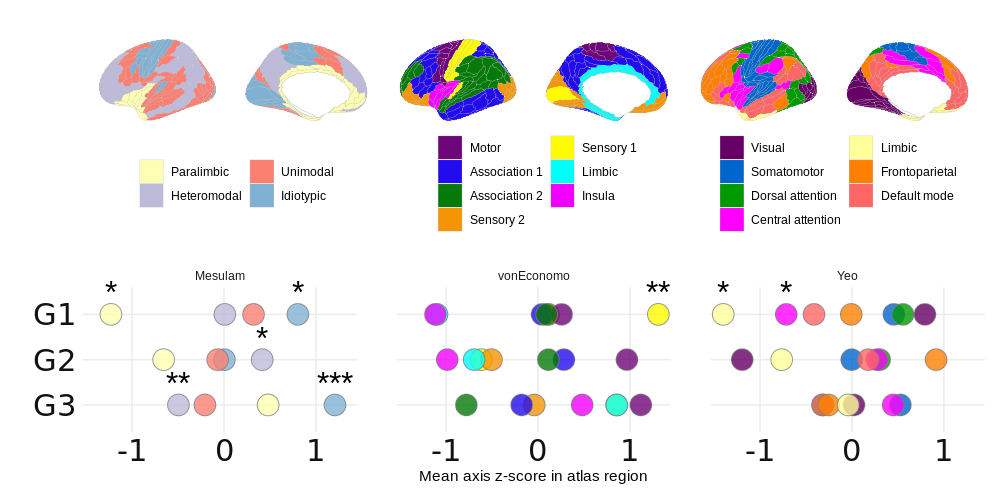

In [301]:
%%R -w 10 -h 5 --units in -r 100 -i atlas_mean_scores_sig_colors -i mesulam_ve_yeo
source('../code/brainPlots.R')
source('../code/Rplots.R')
a1 = plot_hcp_classes(mesulam_ve_yeo, classes=Mesulam, classcolors=Mesulam_colors, classnames=Mesulam_names)
a2 = plot_hcp_classes(mesulam_ve_yeo, classes=vonEconomo, classcolors=vonEconomo_colors, classnames=vonEconomo_names)
a3 = plot_hcp_classes(mesulam_ve_yeo, classes=Yeo, classcolors=Yeo_colors, classnames=Yeo_names)
g1 = plot_atlas_score_dots(atlas_mean_scores_sig_colors)
           
(a1 | a2 | a3) / g1

In [134]:
laminar_diff = np.genfromtxt("../data/mesulam_fsa5.csv", delimiter=',')[:10242]

In [144]:
test = get_mode_of_labels_in_parcellation(parcellation_labels, parcellation_labels)
test = pd.Series(test.astype('int'), index=[i+1 for i in range(180)], name='test')

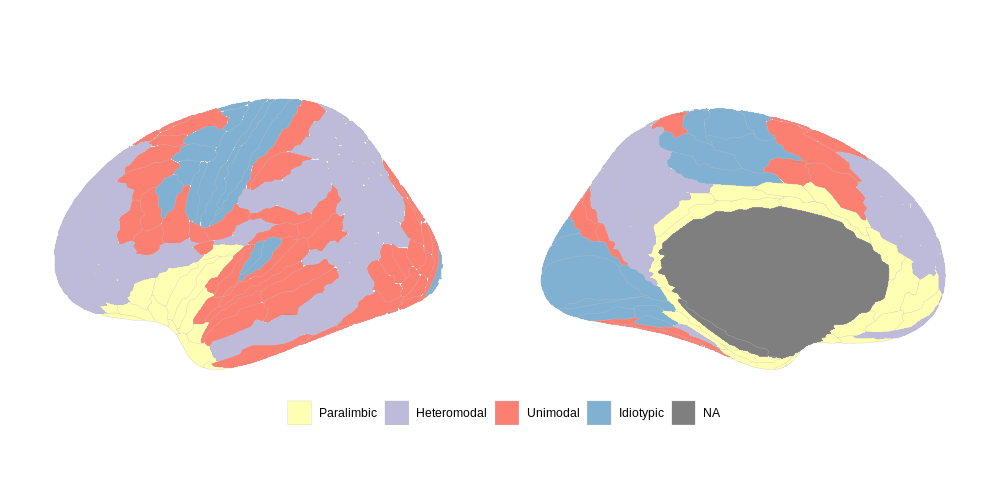

In [292]:
%%R -w 10 -h 5 --units in -r 100 -i laminar_diff_hcp -i ve

plot_laminar_diff <- function(laminar_diff_hcp) {    
    laminar_diff_hcp %>% 
    mutate(region_class=factor(laminar_diff)) %>% 
    mutate(region = recode(label,'7Pl'='7PL')) %>% select(-label) %>%
    ggplot() +
    geom_brain(
        atlas=glasser,
        hemi='left',
        mapping=aes(fill=region_class, geometry=geometry, hemi=hemi, side=side, type=type),
        colour='grey', size=.1
    ) +
    scale_fill_manual(values=brewer.set3(5)[-1], name='') +
    theme_void() +
    theme(legend.position='bottom')

}

plot_laminar_diff(laminar_diff_hcp)

replace the existing scale.





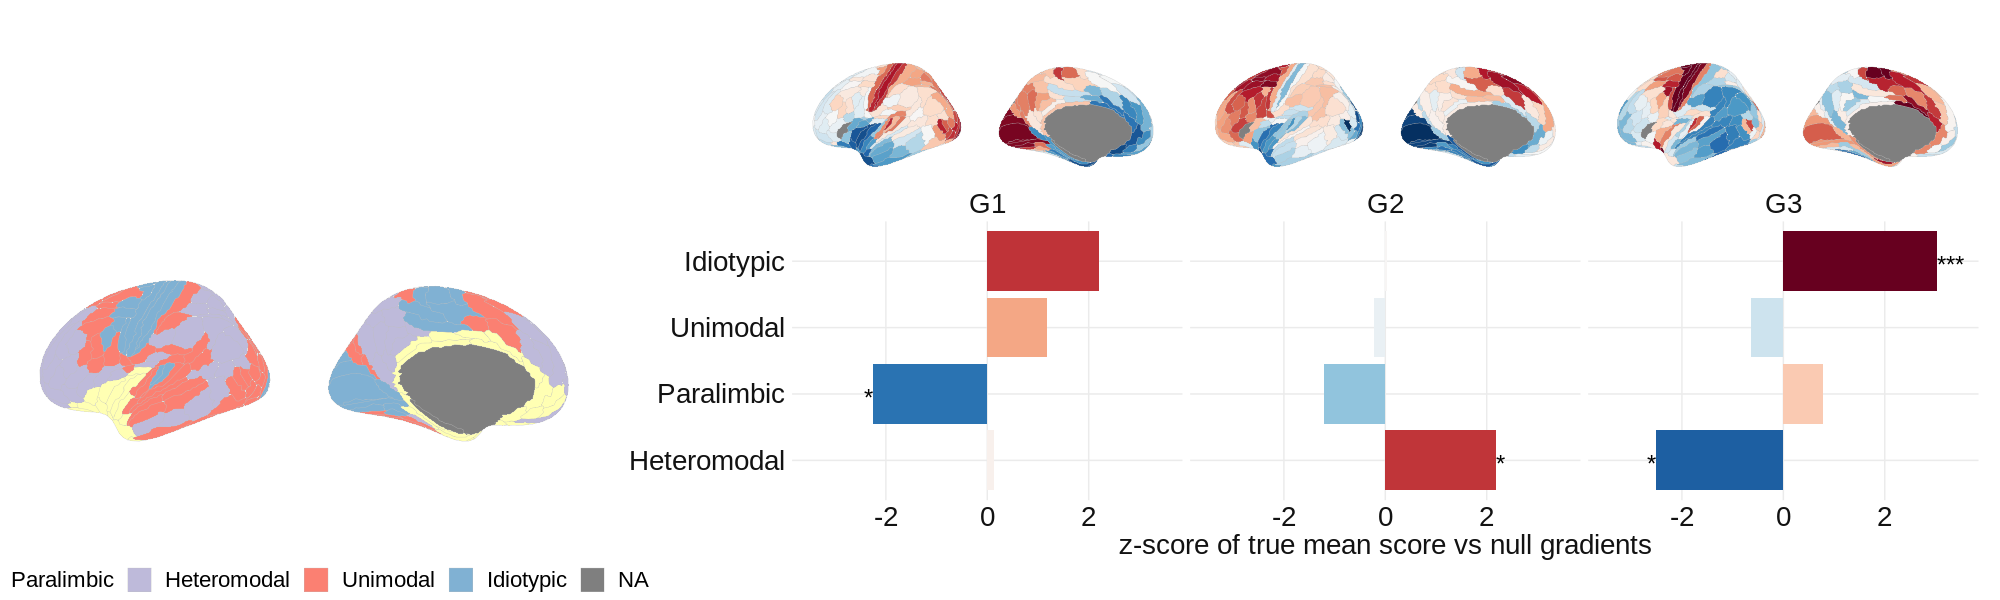

In [386]:
%%R -w 20 -h 6 --units in -r 100 -i null_p -i laminar_diff_hcp -i scores
source("../code/enrichmentsPlots.R")
g0 <- plot_hcp_wide(scores, spacing=1) + theme(strip.text.x=element_blank()) + guides(fill='none')
g1 <- plot_laminar_diff(laminar_diff_hcp)
g2 <- plot_enrichment_bars_z(null_p) + theme(plot.margin=margin(r=10)) + 
    scale_x_continuous(limits=c(-3.5,3.5), name='z-score of true mean score vs null gradients')

layout <- "
##AAAA
BBCCCC
BBCCCC
"

(g0 + g1 + g2 + plot_layout(design=layout)) & theme(text=element_text(size=20))

In [395]:
true_means, null_means = compute_region_means(scores, null_scores, ve)
null_p = compute_null_p(true_means, null_means, order=vonEconomo_labels.values())

replace the existing scale.





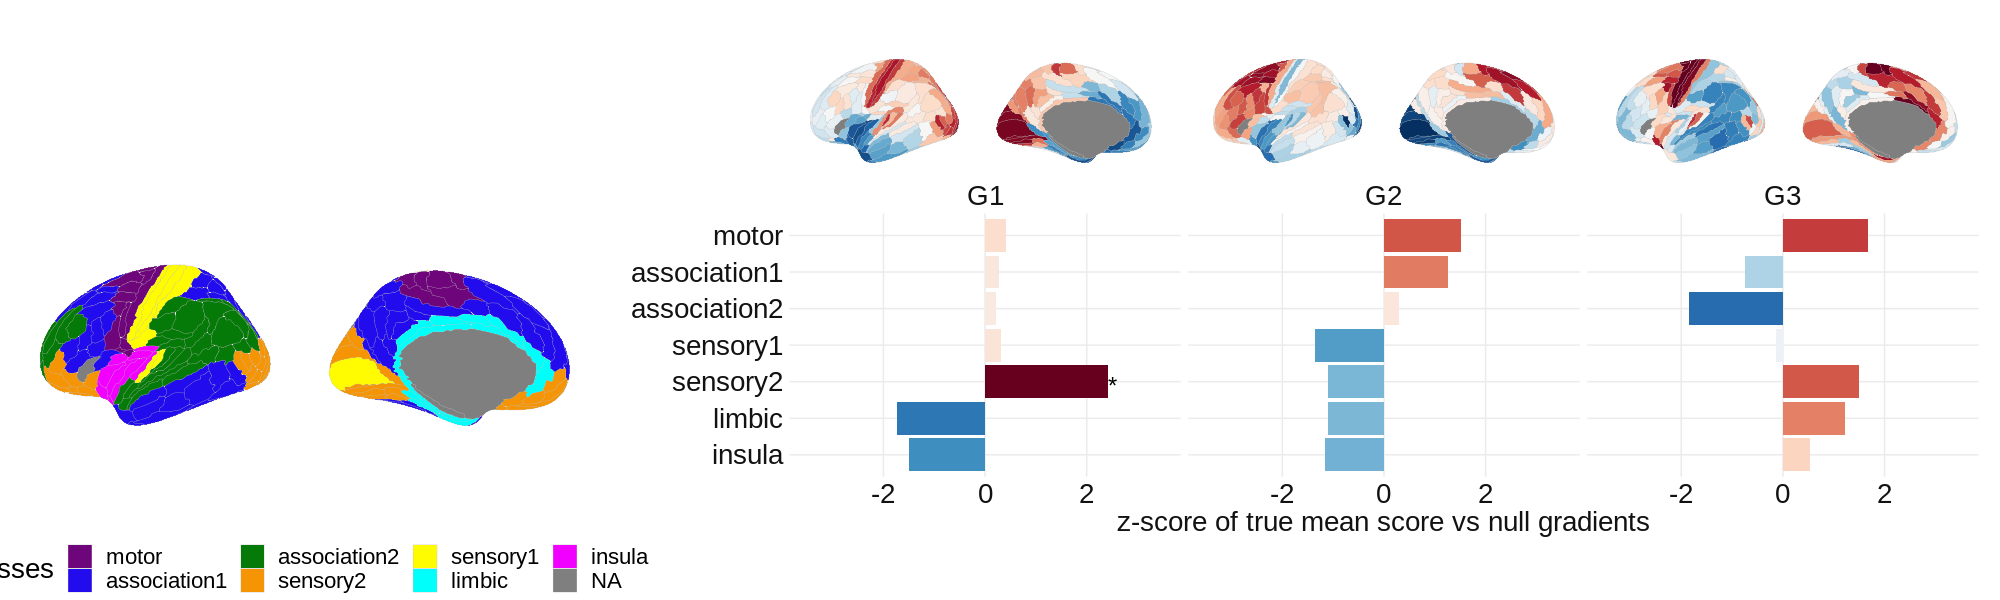

In [403]:
%%R -w 20 -h 6 --units in -r 100 -i null_p -i df_ve_yeo -i scores
source("../code/brainPlots.R")
g0 <- plot_hcp_wide(scores, spacing=1) + theme(strip.text.x=element_blank()) + guides(fill='none')
g1 <- plot_hcp_classes(df_ve_yeo, vonEconomo, vonEconomo.colors, vonEconomo_labels) + theme(legend.position='bottom')
g2 <- plot_enrichment_bars_z(null_p) + theme(plot.margin=margin(r=10)) + 
    scale_x_continuous(limits=c(-3.5,3.5), name='z-score of true mean score vs null gradients')

layout <- "
##AAAA
BBCCCC
BBCCCC
"

(g0 + g1 + g2 + plot_layout(design=layout)) & theme(text=element_text(size=20))

In [390]:
true_means, null_means = compute_region_means(scores, null_scores, yeo)
null_p = compute_null_p(true_means, null_means, order=yeo_labels.values())

replace the existing scale.





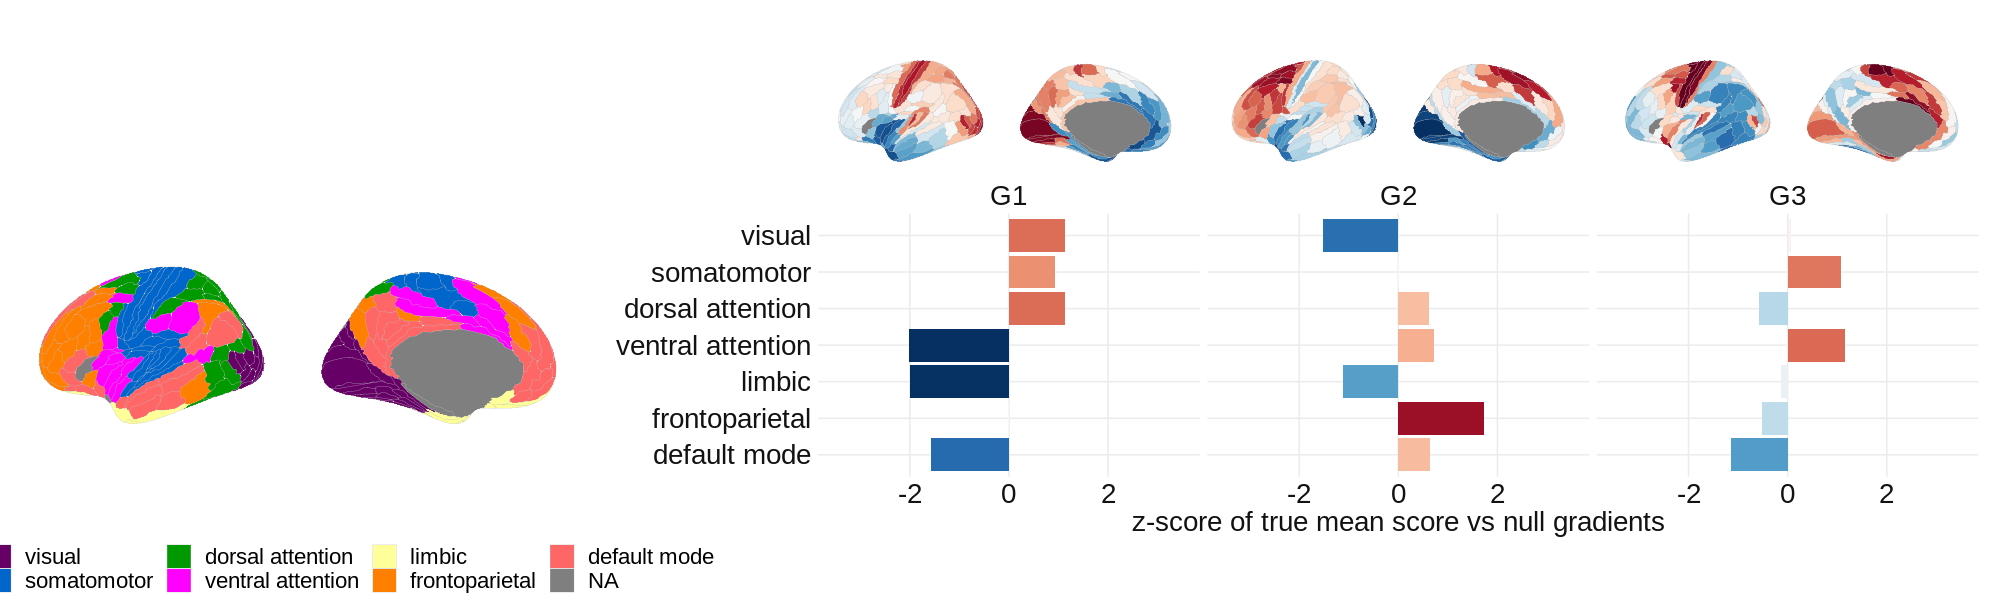

In [391]:
%%R -w 20 -h 6 --units in -r 100 -i null_p -i df_ve_yeo -i scores
source("../code/brainPlots.R")
g0 <- plot_hcp_wide(scores, spacing=1) + theme(strip.text.x=element_blank()) + guides(fill='none')
g1 <- plot_hcp_classes(df_ve_yeo %>% filter(Yeo != 8), Yeo, Yeo.colors, Yeo_labels) + theme(legend.position='bottom')
g2 <- plot_enrichment_bars_z(null_p) + theme(plot.margin=margin(r=10)) + 
    scale_x_continuous(limits=c(-3.5,3.5), name='z-score of true mean score vs null gradients')

layout <- "
##AAAA
BBCCCC
BBCCCC
"

(g0 + g1 + g2 + plot_layout(design=layout)) & theme(text=element_text(size=20))

## Old method

In [298]:
yeo_ve = (pd.read_csv("../data/vonEconomo_Yeo.csv")
          # .loc[lambda x: x['HCP'].str[:2] == 'L_']
          # .assign(HCP = lambda x: x['HCP'].str.replace('L_',''))
          .set_index('HCP')
         )
yeo_ve

,Yeo,vonEconomo,vonEconomo.colors,Yeo.colors,pos_all1,pos_all2,pos_all3
HCP,,,,,,,
L thalamus,8,8,#404040,#404040,10.9190,-9.4175,38.968
L caudate,8,8,#404040,#404040,11.9590,-32.7580,42.329
L putamen,8,8,#404040,#404040,22.9640,-26.7240,34.516
L pallidum,8,8,#404040,#404040,18.0830,-21.7790,33.619
L hippocampus,8,8,#404040,#404040,22.0760,-5.7355,23.134
...,...,...,...,...,...,...,...
R_STSva,7,2,#220ced,#FF6666,-49.1670,-26.5290,18.458
R_TE1m,7,2,#220ced,#FF6666,-59.2610,-14.8330,24.505
R_PI,4,3,#067a08,#FF00FF,-38.9840,-28.0600,23.495


In [402]:
Lobe_colors = {'Fr':"#377EB8", 'Ins':"#E41A1C", 'Occ':"#4DAF4A", 'Par':"#984EA3", 'Temp':"#FF7F00"}
vonEconomo_labels = {1:'motor',2:'association1',3:'association2',4:'sensory2',5:'sensory1',6:'limbic',7:'insula'}
Yeo_labels = {1:'visual',2:'somatomotor',3:'dorsal attention',4:'ventral attention',5:'limbic',6:'frontoparietal',7:'default mode'}

version = dm_hcp_ds8
scores = version.clean_scores()

df_ve_yeo = (
 fetch_hcp()['info'].set_index('id')[['Lobe','x-cog','y-cog','z-cog']]
 .rename({'x-cog':'x','y-cog':'y','z-cog':'z'},axis=1)
 .loc[:180]
 .join(version.clean_scores())
 .assign(L_label = lambda x: ['L_' + l for l in x['label'].astype('str')])
 .join(yeo_ve, on='L_label')
 .assign(Lobecolors = lambda x: x['Lobe'].map(Lobe_colors))
 .assign(vonEconomo_labels = lambda x: x['vonEconomo'].map(vonEconomo_labels))
 .assign(Yeo_labels = lambda x: x['Yeo'].map(Yeo_labels))
)
df_ve_yeo

,Lobe,x,y,z,G1,G2,G3,label,L_label,Yeo,vonEconomo,vonEconomo.colors,Yeo.colors,pos_all1,pos_all2,pos_all3,Lobecolors,vonEconomo_labels,Yeo_labels
id,,,,,,,,,,,,,,,,,,,
1,Occ,100.491589,41.138901,71.637040,2.013669,-2.313416,1.275633,V1,L_V1,1.0,5.0,#fffb00,#660066,11.2100,49.8160,35.575,#4DAF4A,sensory1,visual
2,Occ,132.416667,58.901786,82.059524,1.635389,-0.906801,0.696960,MST,L_MST,1.0,4.0,#f59505,#660066,36.2500,34.0110,37.570,#4DAF4A,sensory2,visual
3,Occ,104.543112,44.481665,103.916749,0.922429,0.163739,0.091310,V6,L_V6,1.0,4.0,#f59505,#660066,10.0960,35.7500,55.243,#4DAF4A,sensory2,visual
4,Occ,102.236656,44.064791,74.401125,1.966769,-1.947837,0.918249,V2,L_V2,1.0,4.0,#f59505,#660066,11.1790,46.8900,36.613,#4DAF4A,sensory2,visual
5,Occ,107.926111,40.632159,76.961153,1.958097,-1.996999,0.688040,V3,L_V3,1.0,4.0,#f59505,#660066,14.5800,47.8790,37.700,#4DAF4A,sensory2,visual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,Temp,142.689243,118.134462,52.832669,-1.069975,-0.492797,-0.955812,STSva,L_STSva,7.0,2.0,#220ced,#FF6666,47.7880,-20.2020,23.128,#FF7F00,association1,default mode
177,Temp,155.554922,101.395287,54.901178,-0.969074,-0.165226,-1.176126,TE1m,L_TE1m,7.0,2.0,#220ced,#FF6666,56.7780,-7.0496,23.176,#FF7F00,association1,default mode
178,Temp,134.650549,124.293407,56.102198,-1.381975,-1.221178,-0.401631,PI,L_PI,4.0,3.0,#067a08,#FF00FF,39.7870,-28.6810,22.045,#FF7F00,association2,ventral attention


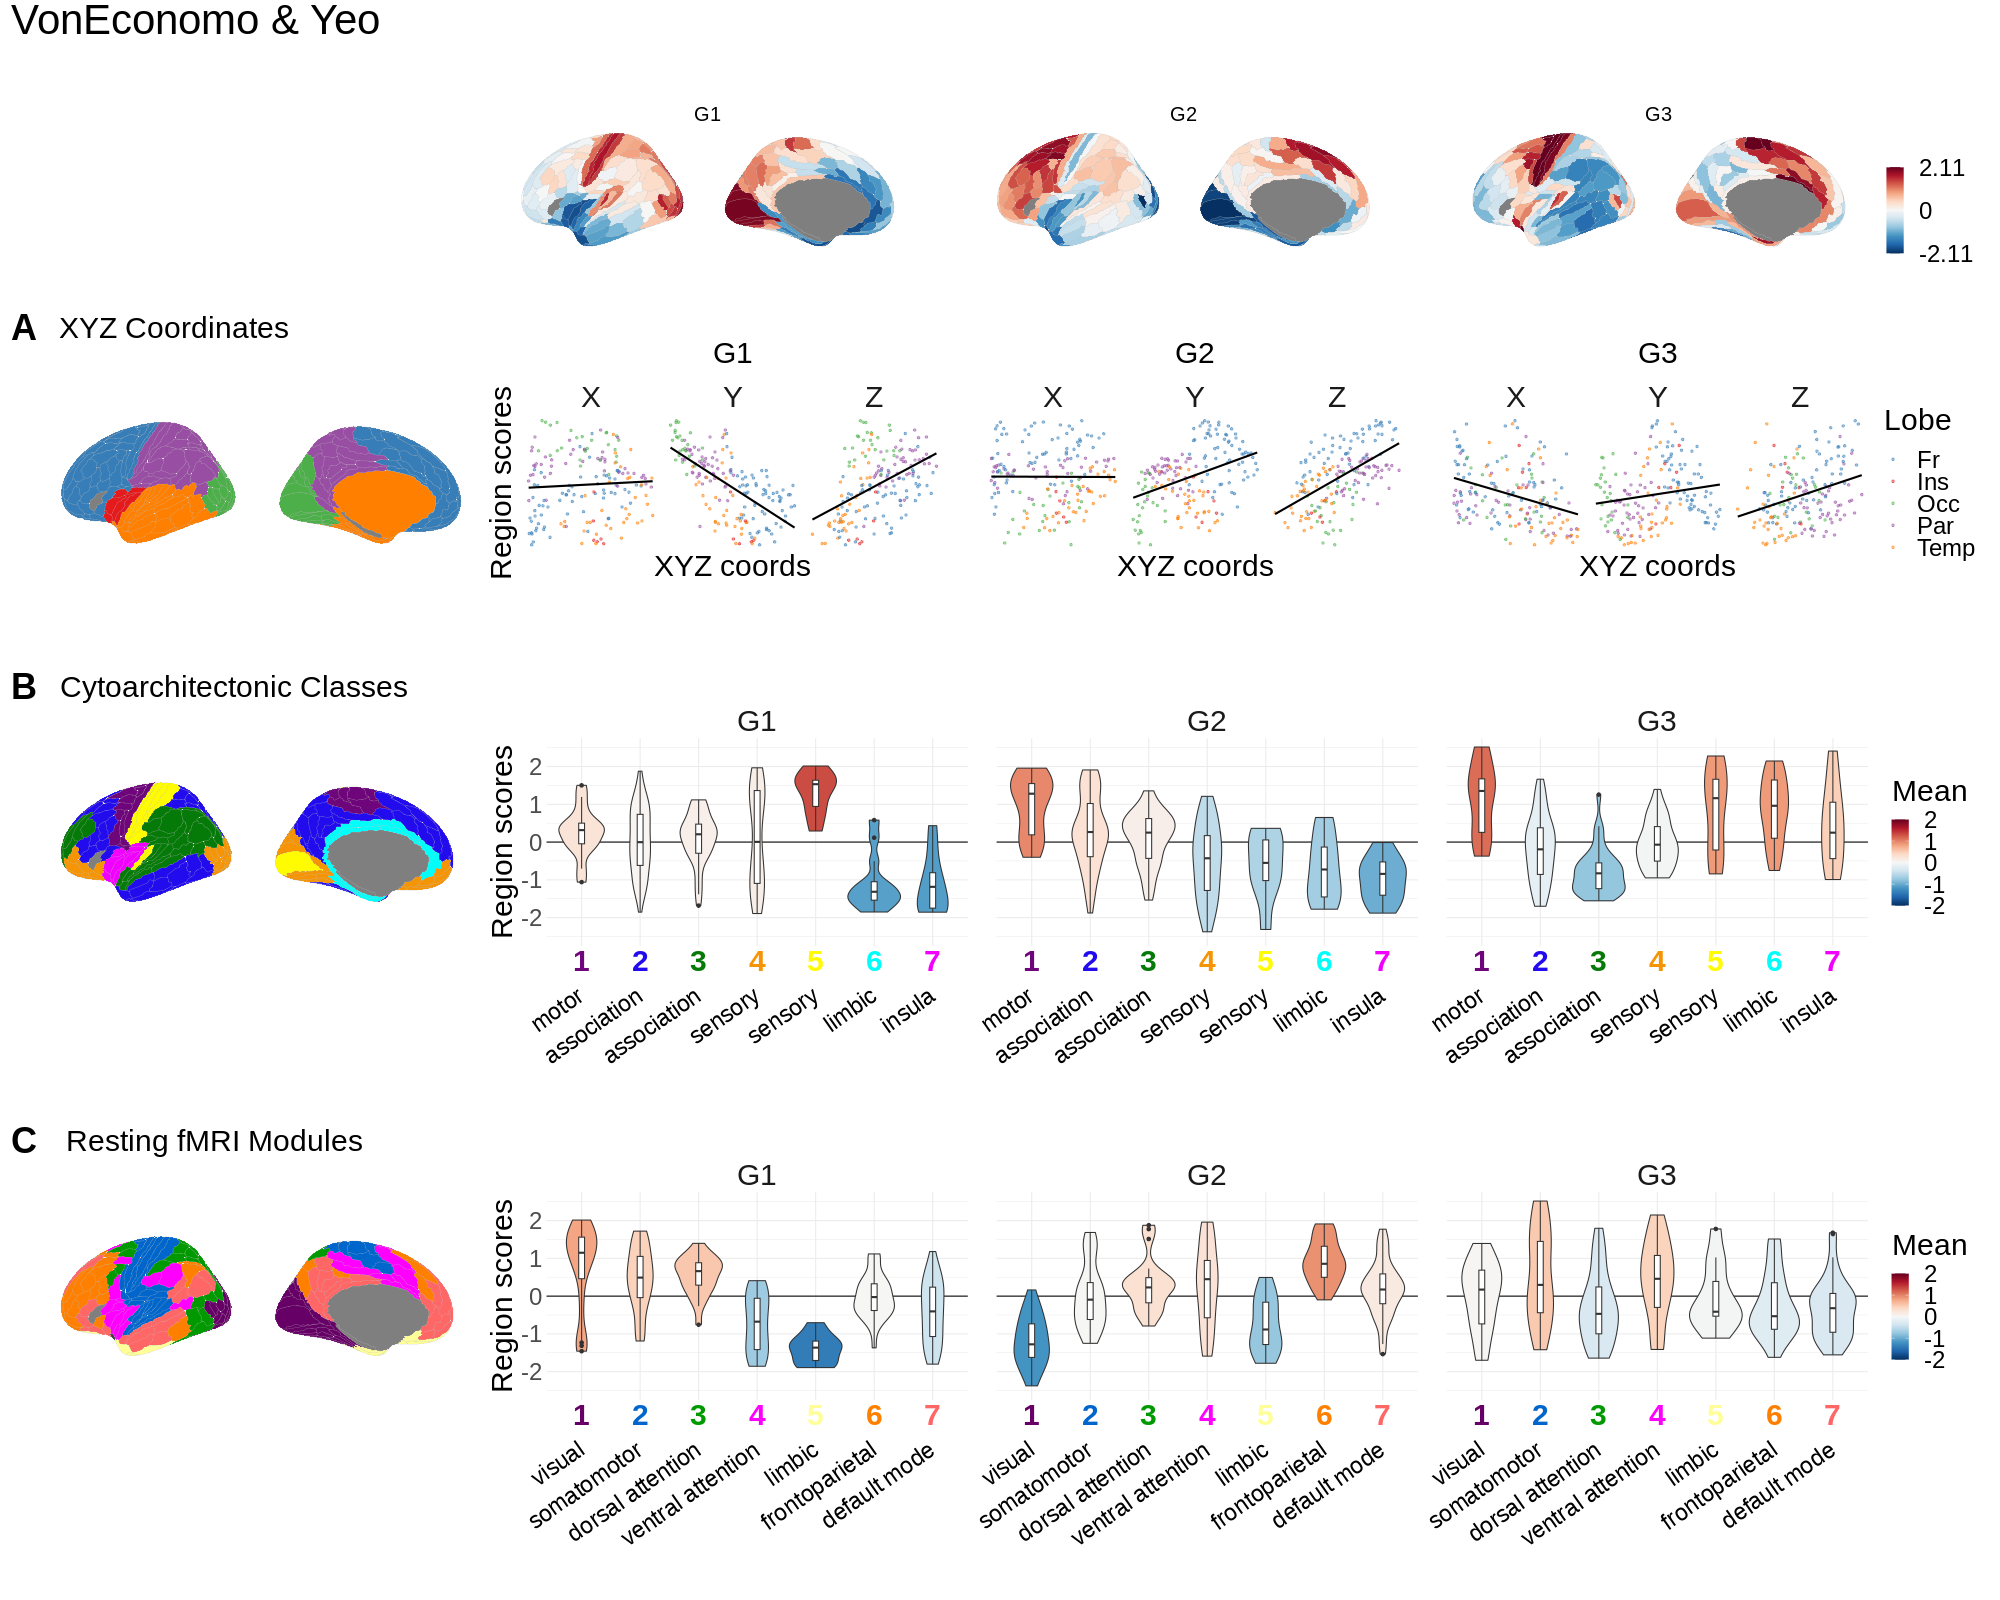

In [8]:
%%R -w 2000 -h 1600 -i df_ve_yeo -i scores

source("../code/Rplots.R")
Lobe_colors = c('#377EB8', '#E41A1C', '#4DAF4A', '#984EA3', '#FF7F00')


g0 <- plot_hcp_classes(df_ve_yeo, classes=Lobe, classcolors=Lobecolors) + ggtitle('XYZ Coordinates') + theme(plot.title=element_text(size=30, hjust=0.1))
g01 <- plot_xyz(df_ve_yeo, G1, 'G1', colors=Lobe_colors)
g02 <- plot_xyz(df_ve_yeo, G2, 'G2', colors=Lobe_colors)
g03 <- plot_xyz(df_ve_yeo, G3, 'G3', colors=Lobe_colors)

g1 <- plot_hcp_classes(df_ve_yeo, vonEconomo, vonEconomo.colors) + ggtitle('Cytoarchitectonic Classes') + theme(plot.title=element_text(size=30, hjust=0.25))
g1x <- plot_violins(df_ve_yeo, vonEconomo, vonEconomo.colors, vonEconomo_labels)
g2 <- plot_hcp_classes(df_ve_yeo, Yeo, Yeo.colors) + ggtitle('Resting fMRI Modules') + theme(plot.title=element_text(size=30, hjust=0.2))
g2x <- plot_violins(df_ve_yeo, 

source("../code/brainPlots.R")
g5 <- plot_hcp_wide(scores)

(
    ((plot_spacer() | g5 + plot_layout(tag_level='new')) + plot_layout(widths=c(1,3)) ) /     
    ((g0 | ((g01|g02|g03) & plot_layout(tag_level='new'))) + plot_layout(widths=c(1,3),guides='collect') ) /
    ((g1 | g1x + plot_layout(tag_level='new')) + plot_layout(widths=c(1,3)) ) / 
    ((g2 | g2x + plot_layout(tag_level='new')) + plot_layout(widths=c(1,3)) ) /
    plot_spacer() & theme(text=element_text(size=30), strip.text=element_text(size=30))
) + plot_layout(heights=c(3,4,4,4,1)) +
    plot_annotation(tag_levels='A',title='VonEconomo & Yeo',
                theme=theme(plot.title=element_text(size=42, hjust=0))) & theme(plot.tag=element_text(size=36, face='bold', vjust=-3.4))